# e-commerce Checkout Dataset
The dataset displays the transactions of an e-commerce store between Apri 24th and November 21st, 2020
* Business metrics
* Site metrics
* category GMV

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
connection = sqlite3.connect('C:/Users/alqai/Downloads/Code _ Data/ecommerce_checkout.db')

In [3]:
cursor = connection.cursor()

### Exploring the dataset

In [4]:
pd.read_sql_query('SELECT * FROM sqlite_master WHERE type = "table"', connection)

,type,name,tbl_name,rootpage,sql
0,table,checkout,checkout,62907,"CREATE TABLE ""checkout"" (\n""index"" INTEGER,\n ..."
1,table,all_data,all_data,58536,"CREATE TABLE ""all_data"" (\n\t""event_time""\tTEX..."


*table : checkout has only one item per order. Table all_data has the full dataset. more that one item per order. I can use only all_data table to get the same outcomes, but I will be using both tables to to practice more sql queries 

### Preprocessing the checkout table  


### Table data types

In [5]:
df = pd.read_sql_query('''SELECT * FROM checkout''', connection)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112406 entries, 0 to 1112405
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   index          1112406 non-null  int64  
 1   event_time     1112406 non-null  object 
 2   order_id       1112406 non-null  float64
 3   product_id     1112406 non-null  float64
 4   category_id    1011910 non-null  float64
 5   category_code  854959 non-null   object 
 6   brand          970633 non-null   object 
 7   price          1011910 non-null  float64
 8   user_id        230783 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 76.4+ MB


In [7]:
df.head(2)

,index,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,0,2020-04-24 11:50:39 UTC,2.294360e+18,1.515966e+18,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2,2020-04-24 14:37:43 UTC,2.294444e+18,2.273948e+18,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18


### Check duplicates 


In [13]:
dstinct = ('''SELECT COUNT(DISTINCT order_id), COUNT(order_id) FROM all_data''')
pd.read_sql_query(dstinct, connection)


,COUNT(DISTINCT order_id),COUNT(order_id)
0,1112406,2633521



The reason why there are duplicated order_ids is that the order has more than one item, so order_id was duplicated. Need to keep it in mind when calculating using order_id

## Business metrics
- GMV (Gross Merchendise Value)
- GMV Orders 
- GMV units
- ASP (Average selling price)
- AOV ( Average order value) 

#### GMV (Gross Merchendise Value) ,  ASP (Average selling price per item), GMV orders, GMV units


In [61]:
GMV = ('''SELECT COUNT(DISTINCT order_id) as GMV_orders,COUNT(product_id)as GMV_units,
               ROUND(SUM(price)) as GMV, MAX(price) as max_item_price,MIN(price) as min_item_price,
               AVG(price) as ASP FROM all_data WHERE price >= 0''')
pd.read_sql_query(GMV, connection)

,GMV_orders,GMV_units,GMV,max_item_price,min_item_price,ASP
0,1097399,2201567,339246428.0,50925.9,0.0,154.093165


####  AOV (Average order value)

In [18]:
aov = pd.read_sql_query('''SELECT SUM(price) / COUNT(DISTINCT order_id) as AOV
FROM all_data''', connection)
aov

,AOV
0,304.966377


####    Orders count over the AOV

In [19]:
num_ord_over = pd.read_sql_query('''SELECT COUNT(DISTINCT order_id) FROM all_data
WHERE price > 305''', connection)
num_ord_over

,COUNT(DISTINCT order_id)
0,221431


#### Median price per item


In [21]:

median = ('''SELECT price as median_price FROM all_data ORDER BY price
LIMIT 1 OFFSET(SELECT COUNT(*) FROM all_data) / 2 ''')

pd.read_sql_query(median, connection)

,median_price
0,34.7


###  Highst price item sold


In [22]:
highst_item = ('''SELECT * 
FROM checkout
WHERE price = (SELECT max(price) FROM checkout)''')

highst_item_df = pd.read_sql_query(highst_item, connection)
highst_item_df.head()

,index,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,28623,2020-06-26 09:10:44 UTC,2.339940e+18,1.515966e+18,2.374499e+18,electronics.video.tv,None,13310.16,1.515916e+18


### Lowest price items


In [23]:
lowest_item = ('''SELECT DISTINCT* 
FROM checkout
WHERE price = (SELECT min(price) FROM checkout WHERE price >0)''')

lowest_item_df = pd.read_sql_query(lowest_item, connection)
lowest_item_df.head(1)

,index,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,25,2020-04-29 03:25:12 UTC,2.297729e+18,1.515966e+18,2.268105e+18,None,sbs,0.02,1.515916e+18


## Site Metrics
- Session Count, Session per customer, Total order per session, Session per Visitor
- Orders per session
- Session conversion ( session with orders / total session)
- Visitor Count
- Customer Count, average visits per customer
- total visits
- order shares and total share for each group


#### Session count 
Assuming that every order or event time from the checkout table is counted as a session since we don't have session information

In [24]:
session = pd.read_sql_query('SELECT COUNT(event_time) as session_count from checkout', connection)
session

,session_count
0,1112406


#### Total visitor count , visitors, customers
Guest checkouts is available since some user_id column has null values choosing checkout table 
since we have only the data for the orders and not the sessions. Lets assume one visitor or customer per orders

using the all_data table, the number of unique customers is 98262 while checkout table is 80354.  If every order comes from a unique customer or visitor, then the checkout data is not acurate and missleading since both tables have the same distinct order_id

#### Orders from customers
Number of unique customers, # of orders from customers, average orders per customer total value, % of the GMV

In [49]:
orders_from_customers = pd.read_sql_query('''SELECT COUNT(DISTINCT user_id) as customers, 
COUNT(user_id) as customer_orders,ROUND(SUM(price)) as '$total_value', COUNT(order_id) / COUNT(DISTINCT user_id) as avg_per_customer
FROM all_data  WHERE user_id != "None "''', connection)
orders_from_customers

,customers,customer_orders,$total_value,avg_per_customer
0,98262,564169,117499096.0,5


#### Count of visitors or non-cusotmers

In [50]:
non_customers = pd.read_sql_query('''SELECT COUNT(DISTINCT order_id) as visitor, 
COUNT(DISTINCT order_id) as orders,ROUND(SUM(price)) as '$total_value'
FROM all_data  WHERE user_id NOT LIKE "%1-9%"''', connection)
non_customers

,visitor,orders,$total_value
0,234818,234818,117499096.0


Cannot get the average number of order for visitors since there is no id for the visitors

## Category Metrics
- Category GMV
- Brand GMV
- Moving average ( 7 days, 14 days, 28 days)

#### Category GMV


In [55]:
category_GMV= ('''SELECT category_code, COUNT(DISTINCT order_id) as order_GMV,
ROUND(SUM(price)) as "$GMV", price /SUM(price) * 100 as percentage,  COUNT(price) as Item_GMV,  
SUM(price) / COUNT(DISTINCT order_id) as "$AVG_Ord_category",
AVG(price) as "$AVG_item"
FROM all_data GROUP BY category_code
ORDER BY COUNT(category_id) DESC''')

category_GMV = pd.read_sql_query(category_GMV, connection)
category_GMV[:5]

,category_code,order_GMV,$GMV,percentage,Item_GMV,$AVG_Ord_category,$AVG_item
0,None,363194,36274337.0,0.000115,612202,99.875926,59.252235
1,electronics.smartphone,248810,102642274.0,0.000408,357682,412.532753,286.965165
2,appliances.kitchen.refrigerators,59481,31507998.0,0.002792,77386,529.715331,407.153718
3,electronics.video.tv,55405,29301226.0,0.001264,71711,528.855264,408.601552
4,computers.notebook,50347,31354631.0,0.002820,71436,622.770593,438.919187


#### Plot Category GMV

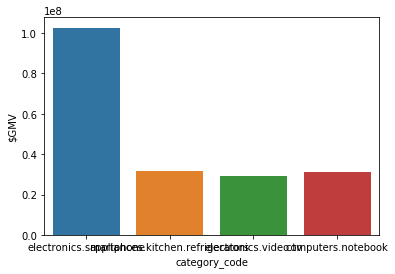

In [52]:
sns.barplot(x ='category_code', y ='$GMV',data = category_GMV[:5] )
plt.show()


Display 4 most preforming categories, None categorized items have more number of orders but less average order

### Brand GMV  


In [54]:
per_brand = ('''SELECT  brand,category_code,count(DISTINCT order_id) as orders_per_brand, ROUND(SUM(price)) as brand_GMV,
price / SUM(price) *100,
COUNT(price) as Item_by_brand,
SUM(price) / COUNT(DISTINCT order_id) as avg_ord_GMV,
AVG(price) as "$AVG_ord_item"
FROM all_data
group by brand, category_code
HAVING brand_GMV >1 AND brand !='None'
ORDER by brand_GMV DESC''')

per_brand_df = pd.read_sql_query(per_brand, connection)
per_brand_df.head()

,brand,category_code,orders_per_brand,brand_GMV,price / SUM(price) *100,Item_by_brand,avg_ord_GMV,$AVG_ord_item
0,samsung,electronics.smartphone,129649,44984338.0,0.002213,178903,346.970189,251.445409
1,apple,electronics.smartphone,33322,35352547.0,0.001185,46030,1060.937115,768.032730
2,samsung,electronics.video.tv,17894,12674670.0,0.013697,22698,708.319553,558.404709
3,lg,electronics.video.tv,15297,10499896.0,0.003527,19234,686.402296,545.902876
4,lenovo,computers.notebook,13711,10257374.0,0.008621,17886,748.112755,573.486190


Brands with average price per item and tend increase the GMV of the brand  * samsung is displayed twice since it has more than one category_code

#### Plot GMV by brand

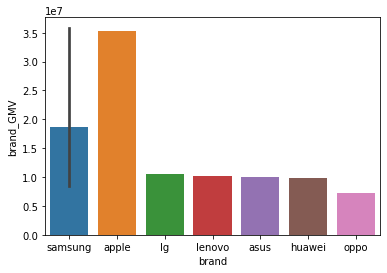

In [33]:
sns.barplot(x ='brand', y ='brand_GMV',data = per_brand_df[:10] )
plt.show()

### Min category GMV 


In [30]:
min_category = ('''SELECT min(mincount) as order_count, category_code
FROM (SELECT category_code, COUNT(category_code) AS mincount FROM all_data GROUP BY category_code) 
where  category_code = 'apparel.shoes'
''')

min_category_df = pd.read_sql_query(min_category, connection)
min_category_df.head()

,order_count,category_code
0,2,apparel.shoes
